In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from ust_wildfire.temperature import average_yearly_temp, average_monthly_temp
from ust_wildfire.wildfire_stat import filter_lifetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [29]:
# Load the data
df_fire = pd.read_csv(f"../data/california.csv")
df_ystat = pd.read_csv(f"../data/results/california_yearly_stat.csv")
df_mstat = pd.read_csv(f"../data/results/california_monthly_stat.csv")
df_temp = pd.read_csv(f"../data/california_monthly_temp.csv")

# Get the data in the time range of interest
years = np.arange(1950, 2021)
temp = average_yearly_temp(df_temp, years)
temp_m = average_monthly_temp(df_temp)
df_ystat = df_ystat[(df_ystat["year"].isin(years))]


# Exclude events with undefined end-time and outliers that has >1 lifetime
df_fire = df_fire.dropna(subset=["end_time"])
df_fire = filter_lifetime(df_fire, 365)

Similar to Alberta, we see similar trend of wildfire statistics in California.

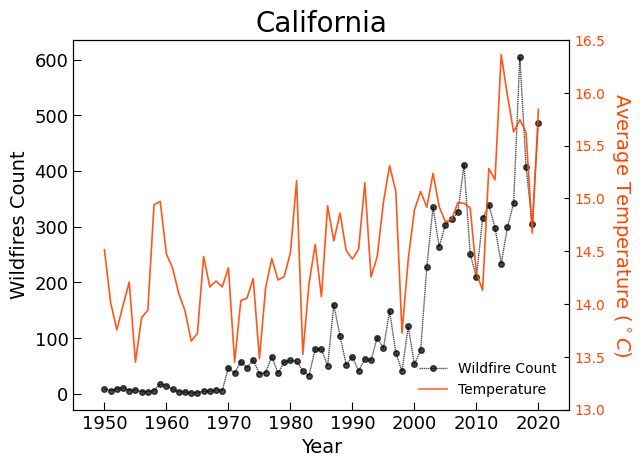

In [30]:
fig, ax = plt.subplots()

ax.plot(df_ystat["year"], df_ystat["count"], color="black", marker="o",
        label="Wildfire Count", ms=4, lw=1, alpha=0.7, linestyle=(0, (1, 0.5)))

ax.set_title("California", fontsize=20)

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Wildfires Count", fontsize=14)
ax.set_xlim(1945, 2025)

ax.tick_params(which="both", direction="in", labelsize=13)
ax.tick_params(which="major", length=6)
ax.tick_params(which="minor", length=4)

# Make the legend
ax.plot([], [], color="orangered", alpha=0.8, lw=1.2, label="Temperature")
ax.legend(loc="lower right", frameon=False, fontsize=10)


# Add the temperature curve
axt = ax.twinx()
axt.plot(years, temp, color="orangered", alpha=0.9, lw=1.2)
axt.set_ylabel(r"Average Temperature ($^\circ C$)", color="orangered",
                fontsize=14, rotation=270, labelpad=20)
axt.tick_params(axis="y", labelcolor="orangered", labelsize=10,
                direction="in")
axt.set_ylim(13, 16.5)

plt.show()

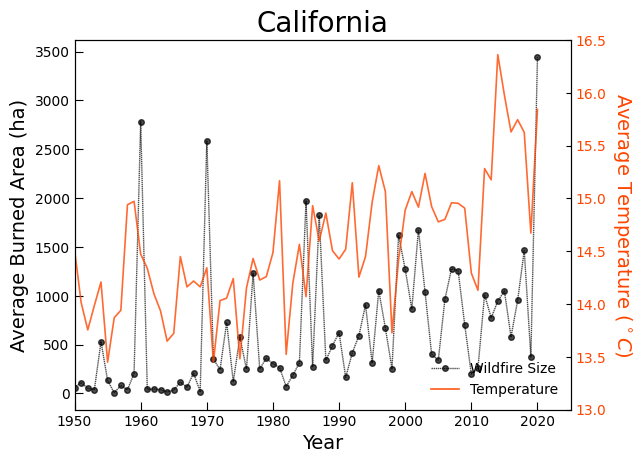

In [31]:
fig, ax = plt.subplots()

ax.plot(df_ystat["year"], df_ystat["avg_size"], color="black", marker="o",
            label="Wildfire Size", ms=4, lw=1, alpha=0.7, linestyle=(0, (1, 0.5)))


ax.set_title("California", fontsize=20)

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Average Burned Area (ha)", fontsize=14)
ax.set_xlim(1950, 2025)

ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(which="major", length=6)
ax.tick_params(which="minor", length=4)

# Make the legend
ax.plot([], [], color="orangered", alpha=0.9, lw=1.2, label="Temperature")
ax.legend(loc="lower right", frameon=False, fontsize=10)


# Add the temperature curve
axt = ax.twinx()
axt.plot(years, temp, color="orangered", alpha=0.8, lw=1.2)
axt.set_ylabel(r"Average Temperature ($^\circ C$)", color="orangered",
                fontsize=14, rotation=270, labelpad=20)
axt.tick_params(axis="y", labelcolor="orangered", labelsize=10,
                direction="in")
axt.set_ylim(13, 16.5)

plt.show()

We can again look at the monthly wildfire statistics, and this time we look at monthly average size. It looks quite different from the Alberta plot --- the average wildfire size is still very large in the winter month, which is somewhat not we are expecting.

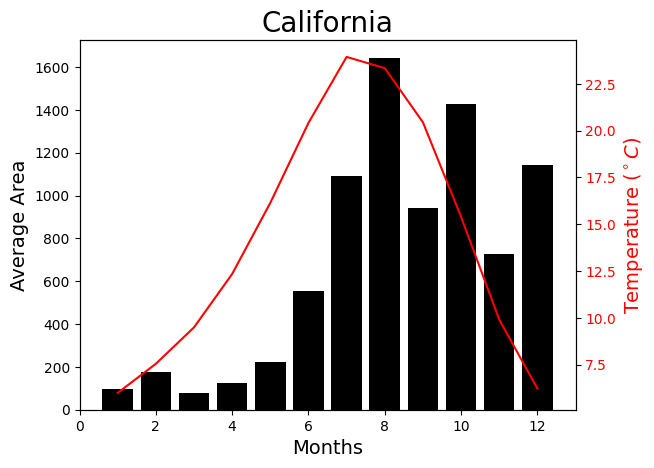

In [32]:
# Note: 
# When I was doing this project, I originally used only the 1950-2019 data,
# because at the time I wasn't sure the post 2020 data is complete or not.
# Turned out, including the post 2020 data changes the results somewhat,
# significantly increase the average burn size in August.
# This probably is because 2020 has particularly bad fires.
# This may worth to take a more close look.

# df_fire = df_fire[(df_fire["year"].isin(np.arange(1950, 2020)))]

fig, ax = plt.subplots()
ax.bar(df_mstat["month"], df_mstat["avg_size"], color="black")

ax.set_title("California", fontsize=20)
ax.set_xlabel("Months", fontsize=14)
ax.set_ylabel("Average Area", fontsize=14)
ax.set_xlim(0, 13)

axt = ax.twinx()
axt.plot(np.arange(1, 13), temp_m, color="red")
axt.set_ylabel(r"Temperature ($^\circ C$)", color="red", fontsize=14)
axt.tick_params(axis="y", labelcolor="red")


plt.show()

This turns out can be attributed to the climate pattern of California. The northern and southern parts of California have quite [different climates](https://en.wikipedia.org/wiki/Climate_of_California), and when we break down the wildfire contribution by location, we see that the winter fire mostly come from southern California.

In [33]:
# Separate northern and southern California; 
# the 37 degree line is often used as the seperator
ns_cutoff = 37

df_north = df_fire.loc[df_fire["lat"] >= ns_cutoff]
df_south = df_fire.loc[df_fire["lat"] <= ns_cutoff]

# Exclude events with undefined sizes
df_north = df_north.dropna(subset=["size", "end_time"])
df_south = df_south.dropna(subset=["size", "end_time"])

months = np.arange(1, 13)
avg_north = np.zeros(12)
avg_south = np.zeros(12)

for m in months:
    df_north_m = df_north.loc[df_north["month"] == m]
    df_south_m = df_south.loc[df_south["month"] == m]

    avg_north[m-1] = np.average(df_north_m["size"])
    avg_south[m-1] = np.average(df_south_m["size"])


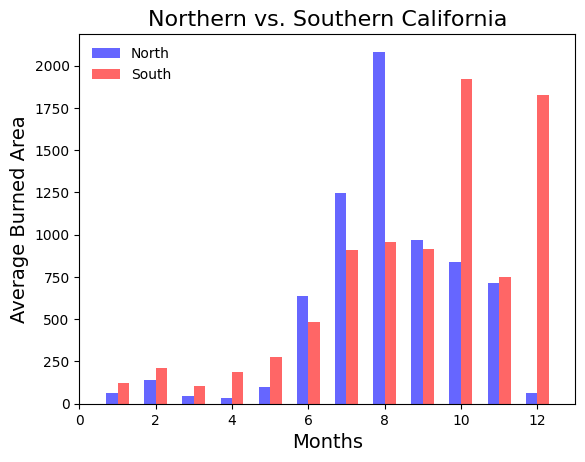

In [34]:
fig, ax = plt.subplots()

ax.bar(months-0.15, avg_north, color="blue", label="North", width=0.3, alpha=0.6)
ax.bar(months+0.15, avg_south, color="red", label="South", width=0.3, alpha=0.6)

ax.set_title("Northern vs. Southern California", fontsize=16)
ax.set_xlabel("Months", fontsize=14)
ax.set_ylabel("Average Burned Area", fontsize=14)
ax.set_xlim(0, 13)

ax.legend(loc="upper left", frameon=False)

plt.show()

Again, we can assign a temperature value to each wildfire event using the same definitions we used for Alberta.

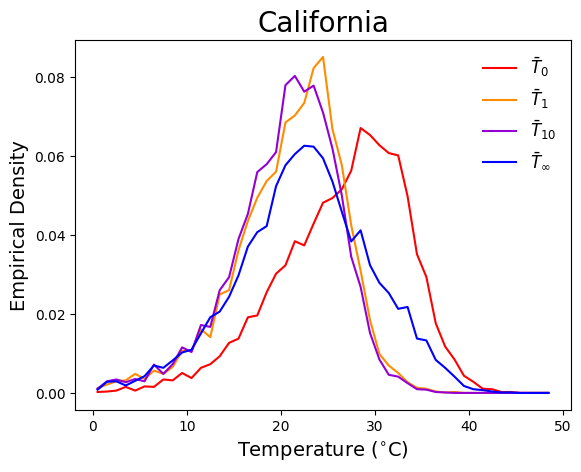

In [35]:
fig, ax = plt.subplots()

temp_var = {"temp_st": {"name": r"$\bar{T}_0$", "color": "red"},
            "temp_1d": {"name": r"$\bar{T}_{1}$", "color": "darkorange"},
            "temp_10d": {"name": r"$\bar{T}_{10}$", "color": "darkviolet"},
            "temp_lt": {"name": r"$\bar{T}_{\infty}$", "color": "blue"}
}

bins = np.arange(0, 50, 1)
centers = (bins[1:] + bins[:-1]) / 2

for v in temp_var:
    hist, _ = np.histogram(df_fire[v].to_numpy(), bins=bins, density=True)
    ax.plot(centers, hist, label=temp_var[v]["name"], 
            color=temp_var[v]["color"])

ax.set_ylabel("Empirical Density", fontsize=14)
ax.set_xlabel("Temperature ($^{\circ}$C)", fontsize=14)
ax.legend(loc="upper right", frameon=False, fontsize=12)
ax.set_title("California", fontsize=20)

plt.show()